# Let's see if we can create a model that can predict whether an online comment is toxic or not

In the lesson on Data Ethics, Rachel emphasized a very important points (Jeremy has been emphasizing that point throughout the lessons too): the model is biased by the data it is fed.

Regarding this, something interesting happened in a Kaggle competition not so long ago.

We will use data from a previous Kaggle Competition: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/

Jigsaw:

The goal of the competition was to build a model that could detect "toxic" comments on online discussion platforms. 

A toxic comment is a comment that can make the other person leave the conversation (racial insult, attack against gender, or religion, etc).

Competitors were given a dataset of text comments, and with every comment, several labels indicating whether the comment was toxic, if it was obscene, or if it contained an insult, etc... 

I've created a subset of this dataset for you, so that training goes faster on Colab. But the whole dataset is also available ;) 

In [0]:
!pip install fastai2 > ../dev/null
!pip install utils > ../dev/null  

In [0]:
from fastai2.text.all import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# figure out in which part of your drive the dataset is
path = Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/')
path.ls()

(#5) [Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/train.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/test.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/sample_submission.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/test_labels.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/fastpractice_df.csv')]

In [0]:
# use pandas to load the fastpractice_df csv file and show its first 5 rows
df = pd.read_csv(path/'fastpractice_df.csv')
df.head()

,Unnamed: 0,text,label
0,6145,Your a racist \n\nSorry your being an avowed and shown racist suggests your opinion is biased. We will not donate any funds now as your on wikipedia.\nBye.,not_toxic
1,65839,"""\n\n Oh genius image-finder... \n\nI am trying to find a PD image of Spokane (horse). I can find several, but cannot verify publication date. I found plenty of stories in PD at Hathi trust and elsewhere, but PD images elude me... I'll go fair use with one if I must, but... can you help? Thanks! Oh, and FYI, I finally got Kenneth and Sarah Ramsey into mainspace! (talk) """,not_toxic
2,36019,"It has been 25 years since I read Jung's book on synchronicity, but there is a summary at the back of the book describing the acausal conncecting principal. While I can see that there are similarities in the 2 philosophies of Astrology & Synchronicity, I do not see that the primary source (Jung) was referring to astrology at the time that he described the principal.\n\nHowever, I am willing to re-read any (few) pages of Jung's works you cite.",not_toxic
3,37936,"Sounds good. But AFAIK, isn't the CWS open to the children of all visitors and members, regardless if they were offered or not?",not_toxic
4,52640,"""\n\n You warned me once. I disagreed with you. You insisted that I had indeed previously made a mistake, somehow breaching policy. That's not a second warning; that's you and I arguing. Viriditas seemed to chime in on your side of the argument. You blocked me. I still didn't do anything else after your first warning. I don't see how that calls for your blocking me, other than your being upset that I disagreed with you. That's not your job, and that's not how Wikipedia is run. talk """,not_toxic


In [0]:
# plot the counts of possible values in the 'label' column of the dataset
df['label'].value_counts()

not_toxic    45447
toxic        15294
Name: label, dtype: int64

In [0]:
# Create DataLoaders that work with text. 
# You are getting better now, so I believe you don't need starter code ;)
dls = TextDataLoaders.from_df(df,
                              valid_pct=0.2,
                              text_col='text',
                              label_col='label'
                              )

assert dls.c == 2

In [0]:
# Show the first three examples of a batch to see if your dataset was properly encoded
dls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj take that ! \n\n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass,toxic
1,xxbos do go fuck off bastard \n xxmaj do xxmaj xxunk xxmaj have a life ? \n go fuck off bastard and yank your cock through your ass . i hate you and hope you go away forever . lame is you fuck your mom . xxwrep 3 die and all that crap . this is for xxunk xxunk \n ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i ass . i,toxic
2,xxbos xxmaj do i know you ? = = because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup fggt ! \n▁ xxmaj do i know you ? because xxmaj you are a xxup,toxic


Each exmaple starts with "xxbos" for "specialtoken(xx) beginningofsentence(bos)"

In [0]:
# Create a learner and fine_tune it for 2 epochs (you can do more, but it may take a while)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.4, metrics=accuracy)
learn.fine_tune(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.500239,0.277463,0.880474,03:36


epoch,train_loss,valid_loss,accuracy,time
0,0.194320,0.194003,0.919987,08:44
1,0.152758,0.167933,0.930853,07:48


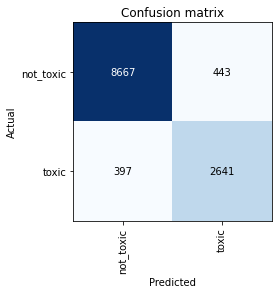

In [0]:
# Create a classification interpretation object from your learner and plot the confusion matrix to see your results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

So far so good, right ? The learning goes steadily and we get good results. The confusion matrix doesn't look too bad either. Jeremy will probably go into more detail about what you can do to get even better results this in upcoming lessons.

 Feel free to come back to this notebook then, I see if you can improve the accuracy. (Of course, I made a sample dataset to have the notebook run more quickly. Feel free to try again with the whole dataset ;) )


# Taking a closer look at the results

NOTE: the following examples were results after my training. They might not work all the time. Maybe your model will predict "a black man" to be a perfecly valid, not toxic sentence. But overall, you'll see that "black" or "white" or "muslim" usually make your model predict a stronger probability for the "toxic" class, even if it doesn't necessarily pass 50% in your case

In [0]:
# So far, so good:
learn.predict('a man')

('not_toxic', tensor(0), tensor([0.7370, 0.2630]))

In [0]:
# alas: 
learn.predict('a black man')

('toxic', tensor(1), tensor([0.4556, 0.5444]))

In [0]:
# but it's not only "black":
learn.predict('a white man')

('toxic', tensor(1), tensor([0.4463, 0.5537]))

In [0]:
# See how every time you had info about the color of a person, your comment becomes "toxic" ?
print('woman:', learn.predict('a woman'))
print('white woman:', learn.predict('a white woman'))
print('black woman:', learn.predict('a black woman'))

woman: ('not_toxic', tensor(0), tensor([0.5999, 0.4001]))


white woman: ('toxic', tensor(1), tensor([0.4053, 0.5947]))


black woman: ('toxic', tensor(1), tensor([0.4006, 0.5994]))


In [0]:
# Let's add religion into the mix :-)
# See how that last probability went THROUGH the roof ?? The model is 0.93% sure the comment is toxic...
learn.predict('I am a black muslim woman who loves her children')

('toxic', tensor(1), tensor([0.0693, 0.9307]))

In [0]:
# Here are a bunch of other sentences you can try as well:
sentences = ['mexicans',
             'canadians',
             'french',
             'italian',
             'I say a random thing about blacks in america',
             'you say a random thing about blacks in america',
             'I say a thing about muslims',
             'you say a thing about muslims',
             'I am a black woman',
             'you are a black woman']

rand_sentence = np.random.choice(sentences)
print(rand_sentence, learn.predict(rand_sentence))

I say a random thing about blacks in america ('not_toxic', tensor(0), tensor([0.6662, 0.3338]))


## What happened ?

In [0]:
# It's possible that whenever people start speaking about ethnicity, the conversation starts becoming heated. Let's investigate:

In [0]:
# Out of 110 comments that contain "mulsim", about a third are "toxic"
df[ df['text'].str.contains('muslim') ]['label'].value_counts()

not_toxic    76
toxic        34
Name: label, dtype: int64

Out of the whole dataset I provided you, the ratio (toxic comments / total) is way lower than that. So the model probably started seing a pattern there... 

For your information, it's _exactly_ what happened in real life. The competition went on, goot models were produced, Jigsaw put them online. Somebody on the internet tried some sentences (see <a href='https://twitter.com/jessamyn/status/901476036956782593'> here </a>) and realized how biased the outcome was...

Here is the table that person came out with:
<img src='illustrations/jigsaw.jpeg'>

If you are interested in how you could mitigate this bias, a second competition happened on Kaggle to tackle exactly that problem. You can find it <a href='https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification'>here</a>. But I don't recommend get into this before the end of the course, because the top solutions are actually pretty involved. 

# Further work
In the path folder, there are other csv files. One contains the test dataset with the comments, another one the labels for the test dataset (the two files are separate because during the competition only the comments were available, the labels were provided afterwards). 

There is also the full training dataset (train.csv) with more comments than in the sample I provided you.



In [0]:
path.ls()

(#5) [Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/train.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/test.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/sample_submission.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/test_labels.csv'),Path('gdrive/My Drive/FastPractice/datasets/jigsaw/jigsaw-toxic-comment-classification-challenge/fastpractice_df.csv')]

If you want more challenge, you can retrain using this whole dataset and see how you would perform on the test set !

Beware though, the train dataset is harder to pass to the DataLoaders Function that the sample I've provided you. There will be some data preprocessing before you can use it ;) 